# Explanatory Data Analysis
___

In [1]:
import os
if os.path.basename(os.getcwd()) != 'food-pairing':
    os.chdir(os.path.dirname(os.getcwd()))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap.umap_ as umap

import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from plotly.subplots import make_subplots
import plotly.graph_objects as go


import plotly.express as px
import plotly.io as pio

from utils.data_loading import read_foods, read_molecules
from utils.ml_utils import find_n_neighbours, molecules2vec

In [2]:
#flavordb_df = molecules2vec(read_foods('flavordb'), read_molecules())
#foodb_df = molecules2vec(read_foods('foodb'), read_molecules())
food_df = molecules2vec(read_foods(), read_molecules())

#flavordb_df = flavordb_df.dropna(subset='category')
#foodb_df = foodb_df.dropna(subset='category')
food_df = food_df.dropna(subset='category')

## Dimensionality reduction
___

In [3]:
y = np.stack(food_df['molecules_vector'].values.tolist(), axis=0)

In [4]:
color_dict ={
    'seafood':'rgb(226,154,134)',#shrimp_color
    'fruit':'rgb(115, 207, 105)', #purple
    'seasoning':'rgb(215, 247, 91)', #piss_yellow
    'nut':'rgb(92,61,14)', #brownish
    'vegetable':'rgb(67, 140, 59)',#green
    'bean':'rgb(54, 66, 17)', #dark_green
    'sugar':'rgb(222, 213, 191)', #white
    'fish':'rgb(34, 124, 157)',#blue
    # 'nan':'black', #black
    'herb':'rgb(107, 194, 158)',#turquiseish
    'dairy':'rgb(255, 164, 0)', #dark yellow
    'meat':'rgb(177,35,35)', #red
    'alcohol':'rgb(194, 121, 52)',
    'grain':'rgb(255, 203, 119)',#idk
    'beverage':'rgb(203, 203, 212)', #pink
    'bakery product':'rgb(253, 240, 213) ',#offwhite
    'mushroom':'rgb(250, 207, 173)' #no idea
}

In [5]:
def plot_reduction(df, embedding, name):
    fig = px.scatter(
        embedding, 
        x=0, y=1, 
        color=df['category'].values,
        hover_data=[df['food'].values],
        labels={'hover_data_0':'food',
                'color': 'category',
                },
        color_discrete_map=color_dict
    #text=flavor_df['food']
    )
    # fig.update_traces(textposition='top center')

    fig.update_layout(
            font=dict(
                family="CMU Serif",
                size=14, 
            )
        )
        
    fig.update_layout( 
        template = 'ggplot2', 
        height=500,
        width = 900,
        margin=dict(l=20, r=20, t=20, b=20),
        # title_text='Visualization by  UMAP'
    )
    config = {
    'toImageButtonOptions': {
        'format': 'png', # one of png, svg, jpeg, webp
        'height': 600,
        'width': 900,
        'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
    }
    }
    
    fig.show(config=config)
    pio.write_image(fig, f"images/{name}.png", scale=6, width=900, height=500)

### tSNE

In [24]:
tsne_params = dict(
    init="pca", 
    perplexity=100,
    method="barnes_hut",
    random_state=42,
    n_iter=1000,
    learning_rate="auto",
)
metric="manhattan"

tsne_flavor_emb = TSNE(metric=metric, **tsne_params).fit_transform(y)
plot_reduction(food_df, tsne_flavor_emb, 'tSNE')

#### Evaluate tSNE

In [7]:
TSNE(metric=metric, **tsne_params).fit(y).kl_divergence_

0.5527867674827576

In [8]:
sklearn.manifold.trustworthiness(y, tsne_flavor_emb, n_neighbors=10,  metric = 'manhattan')

0.9281193009118541

### PCA

In [9]:
pca_flavor_emb = PCA(n_components=2).fit_transform(y)
plot_reduction(food_df, pca_flavor_emb, 'PCA')

#### Evaluate PCA
[source 1](https://towardsdatascience.com/understand-your-data-with-principle-component-analysis-pca-and-discover-underlying-patterns-d6cadb020939)

[source 2](https://www.jcchouinard.com/pca-loadings/)

In [10]:
pca = PCA(n_components=20).fit(y)

In [11]:
n_components = len(pca.explained_variance_ratio_)
explained_variance = pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance)
idx = np.arange(n_components)+1
df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T
mean_explained_variance = df_explained_variance.iloc[:,0].mean() # calculate mean explained variance
# (iii.) Print explained variance as plain text
print('PCA Overview')
print('='*40)
print("Total: {} components".format(n_components))
print('-'*40)
print('Mean explained variance:', round(mean_explained_variance,3))
print('-'*40)
print(df_explained_variance.head(20))
print('-'*40)

PCA Overview
Total: 20 components
----------------------------------------
Mean explained variance: 0.038
----------------------------------------
    explained variance  cumulative
1             0.367996    0.367996
2             0.084370    0.452366
3             0.059948    0.512314
4             0.041337    0.553651
5             0.031421    0.585072
6             0.030455    0.615527
7             0.019989    0.635516
8             0.015792    0.651307
9             0.013451    0.664758
10            0.011046    0.675805
11            0.010547    0.686352
12            0.009848    0.696200
13            0.008909    0.705109
14            0.007743    0.712852
15            0.007319    0.720171
16            0.007050    0.727221
17            0.006119    0.733340
18            0.006051    0.739391
19            0.005595    0.744986
20            0.005258    0.750244
----------------------------------------


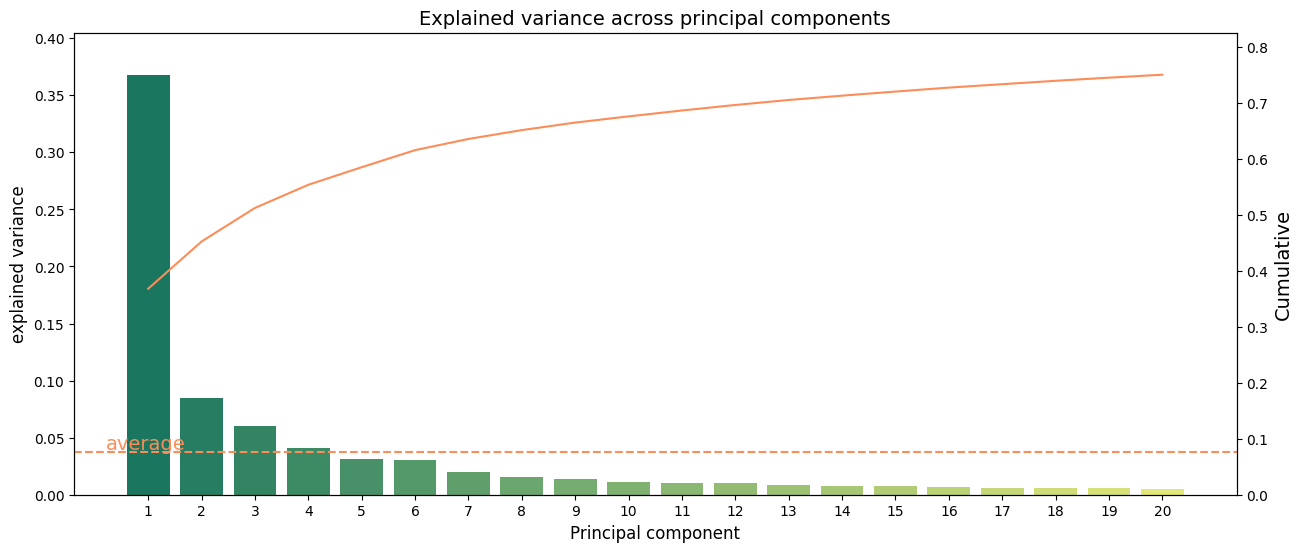

In [12]:
#limit plot to x PC
limit = int(input("Limit scree plot to nth component (0 for all) > "))
if limit > 0:
    limit_df = limit
else:
    limit_df = n_components
df_explained_variance_limited = df_explained_variance.iloc[:limit_df,:]
#make scree plot
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.set_title('Explained variance across principal components', fontsize=14)
ax1.set_xlabel('Principal component', fontsize=12)
ax1.set_ylabel('Explained variance', fontsize=12)
ax2 = sns.barplot(x=idx[:limit_df], y='explained variance', data=df_explained_variance_limited, palette='summer')
ax2 = ax1.twinx()
ax2.grid(False)
ax2.set_ylabel('Cumulative', fontsize=14)
ax2 = sns.lineplot(x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance_limited, color='#fc8d59')
ax1.axhline(mean_explained_variance, ls='--', color='#fc8d59') #plot mean
ax1.text(-.8, mean_explained_variance+(mean_explained_variance*.05), "average", color='#fc8d59', fontsize=14) #label y axis
max_y1 = max(df_explained_variance_limited.iloc[:,0])
max_y2 = max(df_explained_variance_limited.iloc[:,1])
ax1.set(ylim=(0, max_y1+max_y1*.1))
ax2.set(ylim=(0, max_y2+max_y2*.1))
plt.show()

In [13]:
# Extract loadings
pca = PCA(n_components=2).fit(y)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

columns_names = [f"PC{i}" for i in range(2)]
# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, columns=columns_names, index= read_molecules()['common name'].values.tolist())
loadings_df['taste'] = read_molecules()['flavors'].values.tolist()
loadings_df = loadings_df.loc[
    (loadings_df['PC0'] > 0.2) |
    (loadings_df['PC0'] < -0.2) |
    (loadings_df['PC1'] > 0.2) |
    (loadings_df['PC1'] < -0.2)]

In [14]:
loadings_df.sort_values(by='PC1', ascending=True).head(10)

,PC0,PC1,taste
Glucobrassicin,-0.379206,-0.075326,[bitter]
(-)-beta-Pinene,-0.379388,-0.074949,"[woody, pine, resinous, hay, fresh, dry, green]"
1-Popc,-0.380306,-0.072755,[bland]
Pinocarveol,-0.376827,-0.069615,"[woody, pine, balsam, camphor, herbal]"
(-)-Linalool,-0.381187,-0.067801,"[lavender, woody, deep, floral, fresh, natural]"
DL-Liquiritigenin,-0.417462,-0.065696,[bitter]
alpha-Farnesene,-0.382106,-0.065550,"[lavender, sweet, lime, bergamot, wood, citrus..."
(+)-Neomenthol,-0.418875,-0.065352,"[camphoraceous, mentholic, sweet, minty]"
isoliquiritigenin,-0.418875,-0.065352,[bitter]
Farnesal,-0.418875,-0.065352,"[floral, minty]"


In [15]:
print(sum(PCA(n_components=2).fit(y).explained_variance_ratio_))

0.45236612833832734


### UMAP

In [33]:
umap_embedding = umap.UMAP(metric='manhattan', n_neighbors=50, min_dist=1).fit_transform(y)
plot_reduction(food_df, umap_embedding, 'UMAP')

In [17]:
sklearn.manifold.trustworthiness(y, umap_embedding, n_neighbors=10, metric = 'manhattan')

0.8894439953437238

## Clustering - first glance
___

In [21]:
def calculate_metrics(X_real, y_real, y_pred, name, metrics_df):
    if len(np.unique(np.asarray(y_pred))) == 1:
        print(f"No clusters found with {name}")
        metrics_df.loc[len(metrics_df)] = [0, 0, 0, 0, 0, 0]
    else:
        # adjusted rand index
        ari = sklearn.metrics.adjusted_rand_score(y_pred, y_real)
        # silhoutte score
        ss = sklearn.metrics.silhouette_score(X_real, y_pred)
        # davies-bouldin index
        dbx = sklearn.metrics.davies_bouldin_score(X_real, y_pred)
        # mutual information
        mis = sklearn.metrics.mutual_info_score(y_real, y_pred) 
        # calinski-harabasz score
        chs = sklearn.metrics.calinski_harabasz_score(X_real, y_pred)

        metrics_df.loc[len(metrics_df)] = [name, ari, ss, dbx, mis, chs]
    return metrics_df

In [22]:
default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.95,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters":10,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

In [23]:
def sklearn_clustering_algorithms(
        X, y, df, 
        clustering_algorithms,
        visual: str = None,
        ):
    metrics_df = pd.DataFrame(columns=['Algorithm', 'Adjusted Rand Index', 'Silhoutte Score', 'Davies-Bouldin Index',
                                       'Mutual Information', 'Calinski-Harabasz Score'])
    plot_num = 1
    col_num = 1
    names = [name for name, _ in clustering_algorithms]   
    fig = make_subplots(rows=5, cols=2, subplot_titles=names,
                    horizontal_spacing = 0.05,
                    vertical_spacing=0.05)
    for name, algorithm in clustering_algorithms:
        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        X_real = np.stack(X.tolist(), axis=0)
        if visual == 'tSNE':
            flavor_emb = TSNE(metric=metric, **tsne_params).fit_transform(X_real)
        elif visual == 'PCA':
            flavor_emb = PCA(n_components=2).fit_transform(X_real)
        else:
            flavor_emb = umap.UMAP(metric='manhattan', n_neighbors=30, min_dist=0.5).fit_transform(X_real)
            
        metrics_df = calculate_metrics(X_real, y, y_pred, name, metrics_df)
        fig.append_trace(go.Scatter(
            x = flavor_emb[:, 0],
            y = flavor_emb[:, 1],
            mode='markers',
            marker_color=y_pred,
            hoverinfo='text',
            customdata=np.stack((y_pred, df['food'].values), axis=-1),
            hovertemplate='<br>'.join([
                'Cluster: %{customdata[0]}',
                'Food: %{customdata[1]}',
            ]),
            ),
            row=plot_num, col=col_num)
        
        if plot_num == 5:
            col_num = 2
            plot_num = 0
        plot_num += 1


    fig.update_layout(height=2000, width=1000, title_text="Clustering Algorithms", showlegend=False)
    fig.show()
    return metrics_df

In [24]:
# update parameters with dataset-specific values
params = default_base.copy()

X = food_df['molecules_vector'].values
y = food_df['category'].values

# normalize dataset for easier parameter selection
X = StandardScaler().fit_transform(X.tolist())

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=params["n_neighbors"], include_self=False
)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============
ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
two_means = cluster.MiniBatchKMeans(
    n_clusters=params["n_clusters"],
    random_state=params["random_state"],
)
ward = cluster.AgglomerativeClustering(
    n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
)
spectral = cluster.SpectralClustering(
    n_clusters=params["n_clusters"],
    eigen_solver="arpack",
    affinity="nearest_neighbors",
    random_state=params["random_state"],
)
dbscan = cluster.DBSCAN(eps=params["eps"])
hdbscan = cluster.HDBSCAN(
    min_samples=params["hdbscan_min_samples"],
    min_cluster_size=params["hdbscan_min_cluster_size"],
    allow_single_cluster=params["allow_single_cluster"],
)
optics = cluster.OPTICS(
    min_samples=params["min_samples"],
    xi=params["xi"],
    min_cluster_size=params["min_cluster_size"],
)
affinity_propagation = cluster.AffinityPropagation(
    damping=params["damping"],
    preference=params["preference"],
    random_state=params["random_state"],
)
average_linkage = cluster.AgglomerativeClustering(
    linkage="average",
    metric="cityblock",
    n_clusters=params["n_clusters"],
    connectivity=connectivity,
)
birch = cluster.Birch(n_clusters=params["n_clusters"])
gmm = mixture.GaussianMixture(
    n_components=params["n_clusters"],
    covariance_type="full",
    random_state=params["random_state"],
)

clustering_algorithms = (
    ("MiniBatch\nKMeans", two_means),
    ("Affinity\nPropagation", affinity_propagation),
    ("MeanShift", ms),
    ("Spectral\nClustering", spectral),
    ("Ward", ward),
    ("Agglomerative\nClustering", average_linkage),
    ("DBSCAN", dbscan),
    ("HDBSCAN", hdbscan),
    ("OPTICS", optics),
    ("BIRCH", birch),
    ("Gaussian\nMixture", gmm),
)

In [25]:
clustering_metrics = sklearn_clustering_algorithms(X, y, food_df, clustering_algorithms=clustering_algorithms, visual='tSNE')

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



No clusters found with MeanShift


/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_optics.py:995: RuntimeWarning:

divide by zero encountered in divide



In [26]:
clustering_metrics

,Algorithm,Adjusted Rand Index,Silhoutte Score,Davies-Bouldin Index,Mutual Information,Calinski-Harabasz Score
0,MiniBatch\nKMeans,0.067603,0.130633,3.291795,0.421625,41.396310
1,Affinity\nPropagation,0.070380,0.241348,0.275874,1.407810,51.217319
2,0,0.000000,0.000000,0.000000,0.000000,0.000000
3,Spectral\nClustering,0.073999,-0.097297,2.492567,0.410253,29.158886
4,Ward,0.060104,0.209957,1.073824,0.334532,57.819542
5,Agglomerative\nClustering,0.002823,0.531407,0.415495,0.048686,19.816996
6,DBSCAN,-0.006919,-0.218604,1.996801,0.227031,2.299981
7,HDBSCAN,0.046831,-0.001696,2.610107,0.443125,17.643515
8,OPTICS,0.012222,-0.068667,2.875313,0.140435,36.641636
9,BIRCH,0.069595,0.250202,1.966978,0.411980,65.509123


## Clustering - deep dive
___

In [27]:
X = np.stack(food_df['molecules_vector'].values.tolist(), axis=0)
y = food_df['category'].values.tolist()

In [28]:
default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.95,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters":10,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

In [29]:
def plot_clusters(df, embedding, y_pred, name):
    fig = px.scatter(
        embedding, 
        x=0, y=1, 
        color=y_pred,
        hover_data=[df['food'].values],
        labels={'hover_data_0':'food',
                #'color': 'y_pred',
                },
        color_continuous_scale='sunsetdark'
    )
        
    fig.update_layout(
        coloraxis_showscale=False,
        showlegend=False,
        font=dict(
            family="CMU Serif",
            size=14, 
        ),
        template = 'ggplot2', 
        height=600,
        width = 900,
        margin=dict(l=20, r=20, t=20, b=20),
        # title_text='Visualization by  UMAP'
    )
    config = {
    'toImageButtonOptions': {
        'format': 'png', # one of png, svg, jpeg, webp
        'height': 600,
        'width': 900,
        'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
    }
    }
    
    fig.show(config=config)
    pio.write_image(fig, f"images/{name}.png", scale=3, width=900, height=500)

In [30]:
def test_clustering_algorithm(
        X, y, df, 
        algorithm,
        visual: str = None,
        name: str = None
        ):
    metrics_df = pd.DataFrame(columns=['Algorithm', 'Adjusted Rand Index', 'Silhoutte Score', 'Davies-Bouldin Index',
                                       'Mutual Information', 'Calinski-Harabasz Score'])

    algorithm.fit(X)
    if hasattr(algorithm, "labels_"):
        y_pred = algorithm.labels_.astype(int)
    else:
        y_pred = algorithm.predict(X)

    if visual == 'tSNE':
        flavor_emb = TSNE(metric=metric, **tsne_params).fit_transform(X)
    elif visual == 'PCA':
        flavor_emb = PCA(n_components=2).fit_transform(X)
    else:
        flavor_emb = umap.UMAP(metric='manhattan', n_neighbors=30, min_dist=0.5).fit_transform(X)
    
    plot_clusters(df, flavor_emb, y_pred, name)
    metrics_df = calculate_metrics(X, y, y_pred, name, metrics_df)
    
    return metrics_df, y_pred

### KMeans

In [31]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
silhouttes = []
K = range(2, 50)
 
for k in K:
    # Building and fitting the model
    kmeanModel = cluster.KMeans(n_clusters=k, n_init='auto').fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
    silhouttes.append(sklearn.metrics.silhouette_score(np.stack(X.tolist(), axis=0), kmeanModel.labels_.astype(int)))

In [32]:
def plot_line(x, y, x_label, y_label, name):
    fig = px.line(x = x, y = y,
              labels={'x':x_label,
                'y': y_label,
                },)
    fig.update_layout(template = 'ggplot2', height=400, width=500, showlegend=False, font=dict(family="CMU Serif",size=14))
    fig.update_layout(
        margin={'t':10,'l':10,'b':10,'r':10}
    )
    config = {
    'toImageButtonOptions': {
        'format': 'png', # one of png, svg, jpeg, webp
        'height': 400, 'width': 600, 'scale':6
    }}
    
    fig.show(config=config)
    pio.write_image(fig, f"images/{name}.png", scale=6, width=600, height=400)

In [33]:
plot_line(K, silhouttes, 'No of clusters', 'Silhouette score', 'silhoutte')

In [34]:
plot_line(K, distortions, 'No of clusters', 'Distortion', 'distortion')

In [35]:
plot_line(K, inertias, 'No of clusters', 'Inertia', 'elbow')

In [47]:
kmeans = cluster.KMeans(
    n_clusters=5,
    random_state=42,
    n_init='auto'
)

In [48]:
clustering_metric, y_pred = test_clustering_algorithm(X, y, food_df, kmeans, visual='tSNE', name="KMeans")

In [50]:
clustering_metric

,Algorithm,Adjusted Rand Index,Silhoutte Score,Davies-Bouldin Index,Mutual Information,Calinski-Harabasz Score
0,KMeans,0.059808,0.30864,1.265133,0.254158,227.948961


In [49]:
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
[str((food_df.iloc[x])['food']) for x in closest]

['bivalvia (clam, mussel, oyster)',
 'alaska blackfish',
 'clementine',
 'columbidae (dove, pigeon)',
 'herbal tea']

In [51]:
food_df['cluster'] = y_pred

In [81]:
food_df.loc[food_df['cluster'] == 2, 'food'].values.tolist()

['acorn squash',
 'albizia gummifera',
 'bagel',
 'black plum',
 'black raisin',
 'bulgur',
 'buttermilk',
 'cannellini bean',
 'cantaloupe melon',
 'cape gooseberry',
 'chinese plum',
 'chocolate',
 'clementine',
 'crosne',
 'cubanelle pepper',
 'curry powder',
 'eddoe',
 'flour',
 'goji',
 'green apple',
 'green cabbage',
 'green grape',
 'green lentil',
 'green plum',
 'guarana',
 'hawthorn',
 'heart of palm',
 'hibiscus tea',
 'iceberg lettuce',
 'jalapeno pepper',
 'juniperus communis',
 'lantern fruit',
 'mate',
 'mikan',
 'miso',
 'monk fruit',
 'morchella (morel)',
 'mundu',
 'oat bread',
 'pacific herring',
 'partridge berry',
 'pea shoots',
 'piki bread',
 'pita bread',
 'pitaya',
 'plantain',
 'rabbiteye blueberry',
 'red clover',
 'red grape',
 'rice bread',
 'robusta coffee',
 'semolina',
 'sour orange',
 'soy cream',
 'soy sauce',
 'taco shell',
 'tortilla',
 'tostada shell',
 'wampee',
 'water spinach',
 'wheat bread',
 'white bread',
 'white mulberry',
 'wonton wrapper'

In [75]:
[len(food_df.loc[food_df['cluster'] == i, 'food'].values.tolist()) for i in range(5)]

[263, 726, 67, 57, 7]

In [54]:
import itertools
from collections import Counter

def get_cluster_flavors(cluster_no):
    molecules_df = read_molecules()
    cluster_df = food_df[food_df['food'].isin(food_df.loc[food_df['cluster'] == cluster_no, 'food'].values.tolist())]
    cluster_molecules = cluster_df['foodb_ids'].explode().tolist()

    cluster_flavors = [molecules_df.loc[molecules_df['foodbid'] == x, 'flavors'].tolist() for x in cluster_molecules]
    merged = list(itertools.chain(*list(itertools.chain(*cluster_flavors))))
    c = Counter(merged)
    return cluster_df

In [64]:
def get_cluster_molecules(cluster_no):
    molecules_df = read_molecules()
    cluster_df = food_df[food_df['food'].isin(food_df.loc[food_df['cluster'] == cluster_no, 'food'].values.tolist())]
    all_molecules = cluster_df['foodb_ids'].values.tolist()
    cluster_molecules = [x for xs in all_molecules for x in xs]
    c = Counter(cluster_molecules)

    def map_to_name(key):
        new_key = molecules_df.loc[molecules_df['foodbid'] == key, 'common name'].values
        if new_key.size == 0:
            return key
        else:
            return new_key[0] # molecules_df.loc[molecules_df['foodbid'] == key, 'common name'].values[0]
    
    molecules_count = {map_to_name(k):v for k, v in c.items()}
    return molecules_count


In [65]:
def get_the_most_flavors(cluster_no):
    counts = get_cluster_molecules(cluster_no)
    molecules_df = read_molecules()
    df = molecules_df[['common name', 'flavors']]
    # Initialize an empty dictionary to hold flavor counts
    flavor_counts = {}

    # Iterate through the DataFrame
    for index, row in df.iterrows():
        molecule = row['common name']
        flavors = row['flavors']
        count = counts.get(molecule, 0)  # Get the occurrence count of the molecule
        
        for flavor in flavors:
            if flavor in flavor_counts:
                flavor_counts[flavor] += count
            else:
                flavor_counts[flavor] = count

    sorted_flavor_counts = dict(sorted(flavor_counts.items(), key=lambda item: item[1], reverse=True))
    c2 = dict(Counter(sorted_flavor_counts).most_common(5))
    c3 = {k: v/(sum(sorted_flavor_counts.values())) for k, v in c2.items()}
    return c3


In [72]:
cluster_flavor_df = pd.DataFrame(columns=range(5))
for i in range(5):
    flavors = get_the_most_flavors(i)
    formatted_flavors = '\n'.join([f'{key}: {value:.3f}' for key, value in flavors.items()])
    flavors_list = formatted_flavors.split('\n')
    j = 0
    for flavor in flavors_list:
        cluster_flavor_df.loc[j, i] = flavor
        j = j + 1


for i in range(5):
    get_the_most_flavors(i)

In [73]:
cluster_flavor_df

,0,1,2,3,4
0,fatty: 0.048,sweet: 0.062,bitter: 0.053,sweet: 0.056,sweet: 0.059
1,bitter: 0.044,bitter: 0.056,sweet: 0.053,fruity: 0.044,bitter: 0.040
2,sweet: 0.040,green: 0.034,odorless: 0.035,green: 0.038,green: 0.033
3,odorless: 0.034,fruity: 0.026,green: 0.031,bitter: 0.023,fruity: 0.030
4,waxy: 0.030,floral: 0.023,floral: 0.029,waxy: 0.023,floral: 0.024


### DBSCAN

In [98]:
dbscan = cluster.DBSCAN(eps = 1.5) # , min_samples=3)
clustering_metric, y_pred = test_clustering_algorithm(X, y, food_df, dbscan, visual='tSNE', name="DBSCAN")

In [99]:
clustering_metric

,Algorithm,Adjusted Rand Index,Silhoutte Score,Davies-Bouldin Index,Mutual Information,Calinski-Harabasz Score
0,DBSCAN,0.01022,-0.090841,1.672876,0.357429,30.661913


In [100]:
food_df['cluster'] = y_pred
len(food_df.loc[food_df['cluster'] == -1, 'food'].values.tolist())

661

In [101]:
len(food_df) - len(food_df.loc[food_df['cluster'] == -1, 'food'].values.tolist())

459

In [102]:
[(len(food_df.loc[food_df['cluster'] == i, 'food'].values.tolist())) for i in range(-1, 21)]

[661, 54, 89, 39, 31, 80, 16, 69, 11, 11, 17, 6, 9, 16, 5, 6, 0, 0, 0, 0, 0, 0]

In [122]:
food_df.loc[food_df['cluster'] == 15, 'food'].values.tolist()

[]

In [93]:
cluster_flavor_df = pd.DataFrame(columns=range(5))
for i in range(15):
    flavors = get_the_most_flavors(i)
    formatted_flavors = '\n'.join([f'{key}: {value:.3f}' for key, value in flavors.items()])
    flavors_list = formatted_flavors.split('\n')
    j = 0
    for flavor in flavors_list:
        cluster_flavor_df.loc[j, i] = flavor
        j = j + 1


for i in range(5):
    get_the_most_flavors(i)

In [95]:
cluster_flavor_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,sweet: 0.063,sweet: 0.062,sweet: 0.056,sweet: 0.060,sweet: 0.053,sweet: 0.052,bitter: 0.047,sweet: 0.060,sweet: 0.055,sweet: 0.057,sweet: 0.068,sweet: 0.065,sweet: 0.061,sweet: 0.065,sweet: 0.062
1,bitter: 0.060,green: 0.039,green: 0.041,bitter: 0.058,bitter: 0.040,fruity: 0.050,sweet: 0.045,fruity: 0.043,green: 0.041,green: 0.045,fruity: 0.054,bitter: 0.059,bitter: 0.046,fruity: 0.050,bitter: 0.043
2,green: 0.033,fruity: 0.038,bitter: 0.040,green: 0.034,green: 0.039,green: 0.033,fatty: 0.038,green: 0.031,bitter: 0.040,bitter: 0.042,green: 0.045,green: 0.037,woody: 0.036,green: 0.042,fruity: 0.033
3,fruity: 0.024,waxy: 0.025,fruity: 0.026,fruity: 0.025,fruity: 0.030,waxy: 0.026,odorless: 0.034,bitter: 0.024,fruity: 0.026,fruity: 0.040,bitter: 0.031,fruity: 0.026,green: 0.033,bitter: 0.025,green: 0.032
4,odorless: 0.024,fatty: 0.023,fatty: 0.024,fatty: 0.024,fatty: 0.024,fruit: 0.020,green: 0.029,fatty: 0.022,woody: 0.026,fatty: 0.022,waxy: 0.022,floral: 0.024,floral: 0.024,waxy: 0.020,fatty: 0.019


### MeanShift


In [123]:
# estimate bandwidth for mean shift
affinity_propagation = cluster.AffinityPropagation(
    damping=0.95,
    preference=-200,
    random_state=42,
)

In [124]:
clustering_metric, y_pred = test_clustering_algorithm(X, y, food_df, affinity_propagation, visual='tSNE', name="AffinityPropagation")

In [125]:
clustering_metric

,Algorithm,Adjusted Rand Index,Silhoutte Score,Davies-Bouldin Index,Mutual Information,Calinski-Harabasz Score
0,AffinityPropagation,0.0458,0.217404,1.342643,0.401144,78.08561


In [126]:
food_df['cluster'] = y_pred
[(len(food_df.loc[food_df['cluster'] == i, 'food'].values.tolist())) for i in range(0, 20)]

[274, 3, 1, 294, 3, 4, 322, 25, 1, 9, 1, 87, 33, 6, 23, 7, 5, 13, 9, 0]

In [131]:
food_df.loc[food_df['cluster'] == 17, 'food'].values.tolist()

['blue cheese',
 'cheese',
 'cream cheese',
 'domiati cheese',
 'goat cheese',
 'gruyere cheese',
 'limburger cheese',
 'mozzarella cheese',
 'provolone cheese',
 'romano cheese',
 'roquefort cheese',
 'russian cheese',
 'swiss cheese']

In [129]:
cluster_flavor_df = pd.DataFrame(columns=range(19))
for i in range(19):
    flavors = get_the_most_flavors(i)
    formatted_flavors = '\n'.join([f'{key}: {value:.3f}' for key, value in flavors.items()])
    flavors_list = formatted_flavors.split('\n')
    j = 0
    for flavor in flavors_list:
        cluster_flavor_df.loc[j, i] = flavor
        j = j + 1


for i in range(5):
    get_the_most_flavors(i)

In [130]:
cluster_flavor_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,sweet: 0.063,sweet: 0.062,sweet: 0.056,sweet: 0.060,sweet: 0.053,sweet: 0.052,bitter: 0.047,sweet: 0.060,sweet: 0.055,sweet: 0.057,sweet: 0.068,sweet: 0.065,sweet: 0.061,sweet: 0.065,sweet: 0.062,sweet: 0.058,sweet: 0.052,green: 0.050,sweet: 0.063
1,bitter: 0.060,green: 0.039,green: 0.041,bitter: 0.058,bitter: 0.040,fruity: 0.050,sweet: 0.045,fruity: 0.043,green: 0.041,green: 0.045,fruity: 0.054,bitter: 0.059,bitter: 0.046,fruity: 0.050,bitter: 0.043,bitter: 0.045,fruity: 0.037,sweet: 0.044,fruity: 0.042
2,green: 0.033,fruity: 0.038,bitter: 0.040,green: 0.034,green: 0.039,green: 0.033,fatty: 0.038,green: 0.031,bitter: 0.040,bitter: 0.042,green: 0.045,green: 0.037,woody: 0.036,green: 0.042,fruity: 0.033,green: 0.029,green: 0.035,fruity: 0.044,bitter: 0.040
3,fruity: 0.024,waxy: 0.025,fruity: 0.026,fruity: 0.025,fruity: 0.030,waxy: 0.026,odorless: 0.034,bitter: 0.024,fruity: 0.026,fruity: 0.040,bitter: 0.031,fruity: 0.026,green: 0.033,bitter: 0.025,green: 0.032,woody: 0.026,bitter: 0.027,waxy: 0.027,green: 0.039
4,odorless: 0.024,fatty: 0.023,fatty: 0.024,fatty: 0.024,fatty: 0.024,fruit: 0.020,green: 0.029,fatty: 0.022,woody: 0.026,fatty: 0.022,waxy: 0.022,floral: 0.024,floral: 0.024,waxy: 0.020,fatty: 0.019,fruity: 0.022,nutty: 0.022,fatty: 0.026,woody: 0.020
